<a href="https://colab.research.google.com/github/Mursalin1011/Stocks-BackTesting-python/blob/main/Stock_backtesting_practice_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=57b29157f51ba2041d8f869da030a6af75314db5af1f4a21c97c0e3fa59c7fbd
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.trend import MACD, ADXIndicator
from ta.momentum import RSIIndicator
from ta.volume import OnBalanceVolumeIndicator
from ta.volatility import BollingerBands

### Let's use AAPL for our backtesting

In [9]:
ticker = "AAPL"  # You can change this to any stock symbol
df = yf.download(ticker, start="2020-01-01", end="2024-12-31")
df = df[['Close']]  # We'll use only the closing price
df.dropna(inplace=True)


/tmp/ipython-input-2483857969.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


### We'll calculate MA 5 and MA 20

In [4]:
df['MA5'] = df['Close'].rolling(window=5).mean()
print(df['MA5'])
df['MA20'] = df['Close'].rolling(window=20).mean()

Date
2020-01-02           NaN
2020-01-03           NaN
2020-01-06           NaN
2020-01-07           NaN
2020-01-08     72.495596
                 ...    
2024-12-23    251.609055
2024-12-24    252.550790
2024-12-26    254.739508
2024-12-27    255.896716
2024-12-30    255.439813
Name: MA5, Length: 1257, dtype: float64


### Our Signal


> **Buy** when the 5-day Moving Average (MA) crosses **above** the 20-day MA.
<br>
> **Sell** when the 5-day MA crosses below the 20-day MA.



In [ ]:
df['Signal'] = 0  # Initialize
df.loc[df['MA5'] > df['MA20'], 'Signal'] = 1
df.loc[df['MA5'] < df['MA20'], 'Signal'] = -1
df['Position'] = df['Signal'].shift(1)

In [ ]:
# # Step 5: Generate Buy/Sell signals with "hold" and take-profit
# df['Signal'] = np.where(df['MA5'] > df['MA20'], 1,
#                  np.where(df['MA5'] < df['MA20'], -1, np.nan))
# df['Position'] = df['Signal'].ffill().fillna(0)

# # Track entries
# df['Trade Entry Price'] = np.nan
# entry_price = None

# for i in range(1, len(df)):
#     prev_pos = df['Position'].iloc[i - 1]
#     curr_pos = df['Position'].iloc[i]

#     # Record entry price on new long position
#     if prev_pos != 1 and curr_pos == 1:
#         entry_price = df['Close'].iloc[i]
#         df.at[df.index[i], 'Trade Entry Price'] = entry_price

#     # Maintain entry price across holding period
#     elif curr_pos == 1 and entry_price is not None:
#         df.at[df.index[i], 'Trade Entry Price'] = entry_price

#     # Reset entry price when exiting
#     elif curr_pos != 1:
#         entry_price = None

# # Check for take-profit
# take_profit_percent = 0.10
# for i in range(1, len(df)):
#     if df['Position'].iloc[i] == 1:
#         entry = df['Trade Entry Price'].iloc[i]
#         curr = df['Close'].iloc[i]
#         if pd.notna(entry) and (curr - entry) / entry >= take_profit_percent:
#             # Trigger take-profit exit
#             df.at[df.index[i], 'Position'] = 0


### Our custom strategy


In [54]:
df = yf.download("AAPL", start="2020-01-01", end="2024-12-31")[['Open', 'High', 'Low', 'Close', 'Volume']]
df.dropna(inplace=True)
print(type(df['Close']))
print(df['Close'].shape)
df['sq'] = df['Close'].squeeze()
print(df.columns)

/tmp/ipython-input-3736330949.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2020-01-01", end="2024-12-31")[['Open', 'High', 'Low', 'Close', 'Volume']]
[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
(1257, 1)
MultiIndex([(  'Open', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            ( 'Close', 'AAPL'),
            ('Volume', 'AAPL'),
            (    'sq',     '')],
           names=['Price', 'Ticker'])


In [55]:


# 🎯 --- Indicator Calculations ---
df['ADR'] = (df['High'].squeeze() - df['Low'].squeeze()) / df['Close'].squeeze()
df['ADR_SMA'] = df['ADR'].rolling(window=14).mean()
# ✅ MACD (EMA10/EMA20 custom MACD)
macd = MACD(close=df['Close'].squeeze(), window_fast=10, window_slow=20, window_sign=9, fillna=True)
df['MACD_Line'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['MACD_Hist'] = macd.macd_diff()
df['MACD_Bullish'] = df['MACD_Line'] > df['MACD_Signal']

# # ✅ RSI (14)
rsi = RSIIndicator(close=df['Close'].squeeze(), window=14)
df['RSI'] = rsi.rsi()

# # ✅ ADX (14)
adx = ADXIndicator(high=df['High'].squeeze(), low=df['Low'].squeeze(), close=df['Close'].squeeze(), window=14)
df['ADX'] = adx.adx()
df['ADX_Pos'] = adx.adx_pos()
df['ADX_Neg'] = adx.adx_neg()

# # ✅ OBV (On Balance Volume)
obv = OnBalanceVolumeIndicator(close=df['Close'].squeeze(), volume=df['Volume'].squeeze())
df['OBV'] = obv.on_balance_volume()
df['OBV_Change'] = df['OBV'].diff()
df['OBV_Rising'] = df['OBV_Change'] > 0

# # ✅ Bollinger Bands (20 SMA, 2 Std)
bb = BollingerBands(close=df['Close'].squeeze(), window=20, window_dev=2)
df['BB_Mid'] = bb.bollinger_mavg()
df['BB_Upper'] = bb.bollinger_hband()
df['BB_Lower'] = bb.bollinger_lband()
df['BB_Breakout'] = df['Close'].squeeze() > df['BB_Mid']

# # ✅ Bollinger Band Squeeze Detection
# df['BB_Squeeze'] = df['BB_Width'] < df['BB_Width'].rolling(window=20).quantile(0.25)

# # ✅ EMA 20 & EMA 50
df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA50'] = df['Close'].ewm(span=50, adjust=False).mean()

# # 🧼 Clean up any leftover NaNs from indicators
df.dropna(inplace=True)

# # ✅ Preview final DataFrame (last few rows)
df[['Close', 'MACD_Line', 'MACD_Signal', 'RSI', 'ADX', 'BB_Lower', 'BB_Upper', 'EMA20', 'EMA50']].tail()


Price,Close,MACD_Line,MACD_Signal,RSI,ADX,BB_Lower,BB_Upper,EMA20,EMA50
Ticker,AAPL,,,,,,,,
Date,,,,,,,,,
2024-12-23,254.655716,4.575211,4.300293,73.085651,42.179305,231.653317,257.221381,244.863960,236.921649
2024-12-24,257.578674,4.844195,4.409073,75.750285,43.476235,232.966257,258.435348,246.074885,237.731728
2024-12-26,258.396667,5.030253,4.533309,76.452877,44.908751,234.106260,259.685579,247.248388,238.542118
2024-12-27,254.974930,4.784627,4.583573,67.626270,44.213559,236.053144,259.799725,247.984249,239.186542
2024-12-30,251.593079,4.227147,4.512288,60.225562,42.735271,237.873682,259.462608,248.327947,239.673073


In [56]:
# Entry signal conditions
df['entry_signal_count'] = (
    (df['MACD_Bullish']) +
    ((df['RSI'] > 40) & (df['RSI'] < 60) & (df['RSI'].diff() > 0)) +
    (df['ADX'] > 20) +
    (df['BB_Breakout']) +
    (df['OBV_Rising'])
)

# Entry signal: At least 3 indicators + ADR_SMA > 1.0
df['Entry_Signal'] = (df['entry_signal_count'] >= 3) & (df['ADR_SMA'] > 1.0)

In [57]:
# Exit signal conditions
df['MACD_Bearish'] = df['MACD_Line'] < df['MACD_Signal']
df['RSI_Overbought'] = (df['RSI'] > 70) & (df['RSI'].diff() < 0)
df['ADX_Weak'] = df['ADX'] < 20
df['BB_Weak'] = (df['Close'].squeeze() < df['BB_Mid']) | (df['Close'].squeeze() >= df['BB_Upper'])
df['OBV_Falling'] = df['OBV_Change'] <= 0
df['ADR_Drop'] = df['ADR_SMA'] < 1.0

df['exit_signal_count'] = (
    (df['MACD_Bearish']) +
    (df['RSI_Overbought']) +
    (df['ADX_Weak']) +
    (df['BB_Weak']) +
    (df['OBV_Falling'])
)

### Simulation of trades

In [58]:
# Simulate trading
df['Position'] = 0
holding = False

for i in range(1, len(df)):
    if not holding and df['Buy_Signal'].iloc[i]:
        df.at[df.index[i], 'Position'] = 1
        holding = True
    elif holding and df['Sell_Signal'].iloc[i]:
        df.at[df.index[i], 'Position'] = 0
        holding = False
    else:
        df.at[df.index[i], 'Position'] = df['Position'].iloc[i-1]

KeyError: 'Buy_Signal'

In [ ]:
# Calculate strategy returns
df['Market_Returns'] = df['Close'].pct_change()
df['Strategy_Returns'] = df['Market_Returns'] * df['Position']

# Cumulative returns
df['Cumulative_Market'] = (1 + df['Market_Returns']).cumprod()
df['Cumulative_Strategy'] = (1 + df['Strategy_Returns']).cumprod()

In [ ]:
# Plot
plt.figure(figsize=(14, 6))
plt.plot(df['Cumulative_Market'], label='Market Return (Buy & Hold)')
plt.plot(df['Cumulative_Strategy'], label='Strategy Return', linestyle='--')
plt.title('Trading Strategy vs Buy & Hold on AAPL')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [53]:
initial_cash = 100000
df['Daily Return'] = df['Close'].pct_change()
df['Strategy Return'] = df['Daily Return'] * df['Position']
df['Cumulative Market Return'] = (1 + df['Daily Return']).cumprod()
df['Cumulative Strategy Return'] = (1 + df['Strategy Return']).cumprod()

KeyError: 'Position'

### Plotting the results

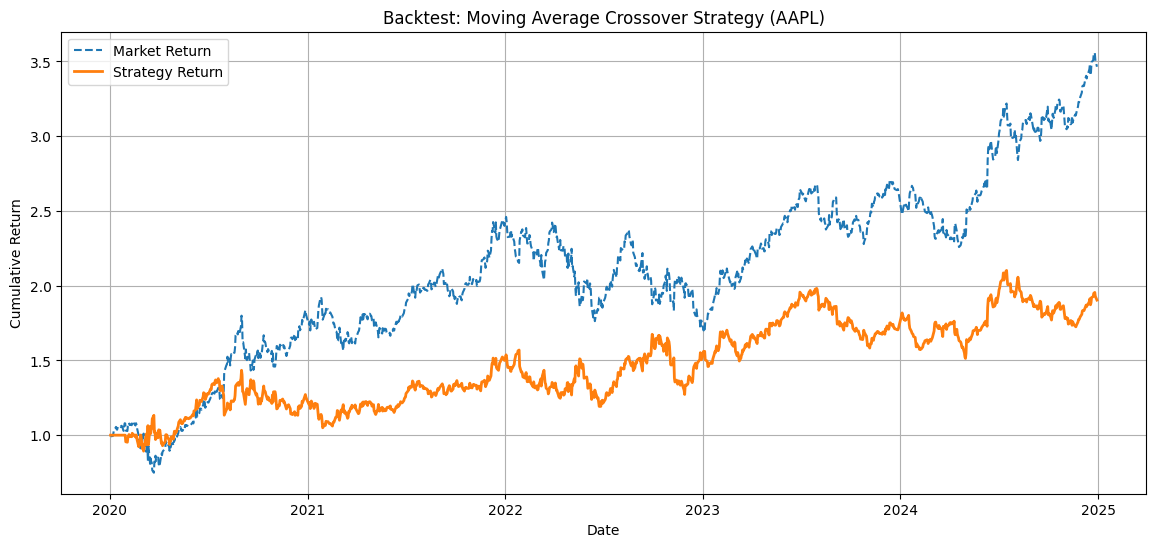

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df['Cumulative Market Return'], label='Market Return', linestyle='--')
plt.plot(df['Cumulative Strategy Return'], label='Strategy Return', linewidth=2)
plt.title(f"Backtest: Moving Average Crossover Strategy ({ticker})")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
total_return = df['Cumulative Strategy Return'].iloc[-1] - 1
market_return = df['Cumulative Market Return'].iloc[-1] - 1
num_trades = df['Position'].diff().abs().sum()

sharpe_ratio = np.mean(df['Strategy Return']) / np.std(df['Strategy Return']) * np.sqrt(252)

print(f"🔹 Total Strategy Return: {total_return:.2%}")
print(f"🔹 Buy & Hold Return:     {market_return:.2%}")
print(f"🔹 Number of Trades:      {num_trades:.0f}")
print(f"🔹 Sharpe Ratio:          {sharpe_ratio:.2f}")

🔹 Total Strategy Return: 90.34%
🔹 Buy & Hold Return:     246.45%
🔹 Number of Trades:      121
🔹 Sharpe Ratio:          0.57


In [67]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.trend import MACD, ADXIndicator
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.volume import OnBalanceVolumeIndicator

# Load AAPL data
df = yf.download("AAPL", start="2020-01-01", end="2024-12-31")[['Open', 'High', 'Low', 'Close', 'Volume']]
df.dropna(inplace=True)

# Indicators
macd = MACD(close=df['Close'].squeeze(), window_fast=10, window_slow=20, window_sign=9)
df['MACD_Line'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['MACD_Buy'] = df['MACD_Line'] > df['MACD_Signal']
df['MACD_Sell'] = df['MACD_Line'] < df['MACD_Signal']

rsi = RSIIndicator(close=df['Close'].squeeze(), window=14)
df['RSI'] = rsi.rsi()
df['RSI_Buy'] = df['RSI'] > 40
df['RSI_Sell'] = df['RSI'] > 70

adx = ADXIndicator(high=df['High'].squeeze(), low=df['Low'].squeeze(), close=df['Close'].squeeze(), window=14)
df['ADX'] = adx.adx()
df['ADX_Strong'] = df['ADX'] > 20

bb = BollingerBands(close=df['Close'].squeeze(), window=20, window_dev=2)
df['BB_Mid'] = bb.bollinger_mavg()
df['BB_Breakout'] = df['Close'].squeeze() > df['BB_Mid']
df['BB_Stall'] = df['Close'].squeeze() < df['BB_Mid']

obv = OnBalanceVolumeIndicator(close=df['Close'].squeeze(), volume=df['Volume'].squeeze())
df['OBV'] = obv.on_balance_volume()
df['OBV_Change'] = df['OBV'].diff()
df['OBV_Rising'] = df['OBV_Change'] > 0
df['OBV_Falling'] = df['OBV_Change'] < 0

# Simulated Entry Signal (3 or more bullish indicators)
df['Buy_Signal'] = (
    df[['MACD_Buy', 'RSI_Buy', 'ADX_Strong', 'BB_Breakout', 'OBV_Rising']]
    .sum(axis=1) >= 3
)

# Simulated Exit Signal (2 or more bearish indicators)
df['Sell_Signal'] = (
    df[['MACD_Sell', 'RSI_Sell', 'BB_Stall', 'OBV_Falling']]
    .sum(axis=1) >= 2
)

# Simulate trading
df['Position'] = 0
holding = False

for i in range(1, len(df)):
    if not holding and df['Buy_Signal'].iloc[i]:
        df.at[df.index[i], 'Position'] = 1
        holding = True
    elif holding and df['Sell_Signal'].iloc[i]:
        df.at[df.index[i], 'Position'] = 0
        holding = False
    else:
        df.at[df.index[i], 'Position'] = df['Position'].iloc[i-1]



/tmp/ipython-input-2118406413.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2020-01-01", end="2024-12-31")[['Open', 'High', 'Low', 'Close', 'Volume']]
[*********************100%***********************]  1 of 1 completed


In [68]:
initial_cash = 100000
cash = initial_cash
position = 0
shares = 0
portfolio_values = []

for i in range(len(df)):
    price = df['Close'].iloc[i]
    signal = df['Position'].iloc[i]

    # Entry: Buy if not in position and signal is 1
    if signal == 1 and position == 0:
        shares = cash / price
        cash = 0
        position = 1

    # Exit: Sell if in position and signal is 0
    elif signal == 0 and position == 1:
        cash = shares * price
        shares = 0
        position = 0

    # Portfolio value = cash + shares*price
    portfolio_value = cash + shares * price
    portfolio_values.append(portfolio_value)

df['Strategy_Portfolio'] = portfolio_values


In [69]:
df['BuyHold_Portfolio'] = initial_cash * (df['Close'] / df['Close'].iloc[0])


/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


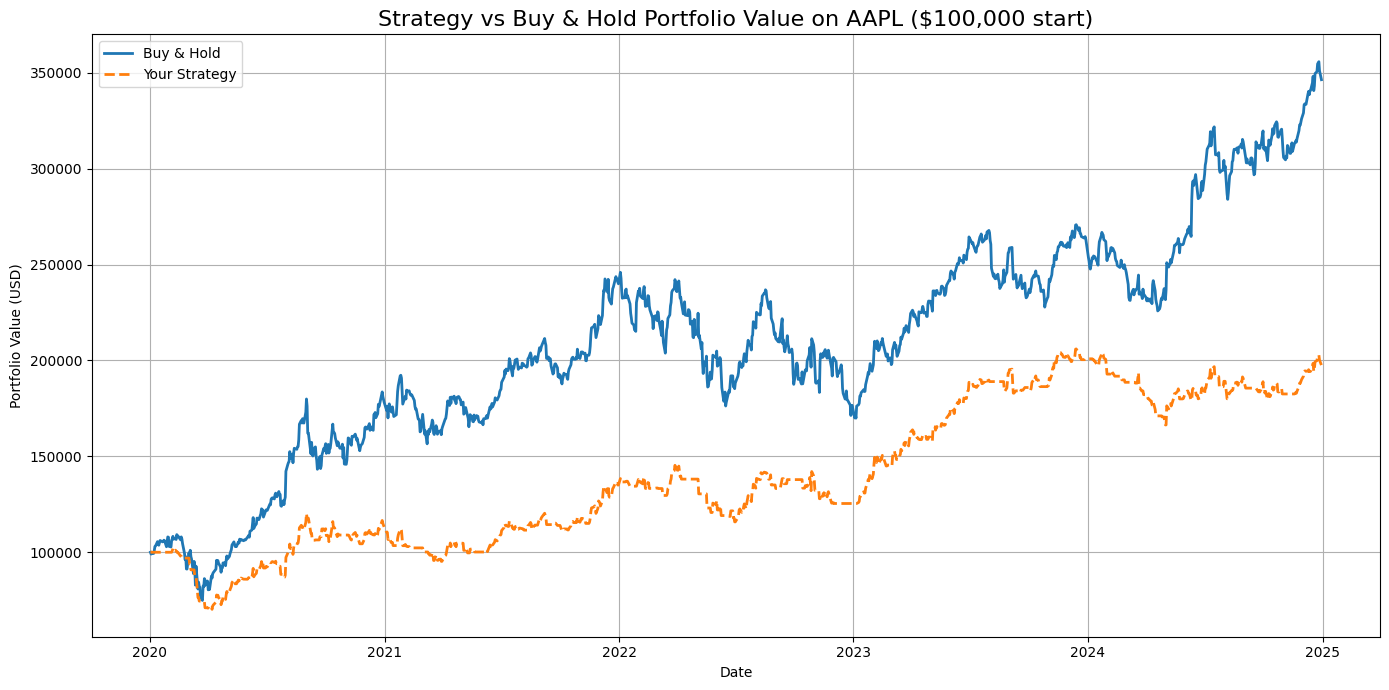

In [70]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['BuyHold_Portfolio'], label='Buy & Hold', linewidth=2)
plt.plot(df.index, df['Strategy_Portfolio'], label='Your Strategy', linestyle='--', linewidth=2)

plt.title("Strategy vs Buy & Hold Portfolio Value on AAPL ($100,000 start)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Portfolio Value (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
